<a href="https://colab.research.google.com/github/nurhabibrs/Capstone-Project-B21-CAP0463/blob/main/Anarki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anarki : First Layer Detection of Drug Abuse by Face Recognition Based on Mobile Apps**

### **Load Dataset**



In [1]:
import numpy as np
import os
import tensorflow as tf
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
# Check TF 2 Version
tf.__version__

'2.5.0'

In [3]:
# Mengambil Dataset
dataset_url = "https://raw.githubusercontent.com/amaripujo/drug_abused/main/drug_abused.tar.gz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='drug_abused', untar=True)
data_dir = pathlib.Path(data_dir)

3989504/3985931 [==============================] - 0s 0us/step


In [4]:
# Mengecek Directori Dataset
print(data_dir)

/root/.keras/datasets/drug_abused


In [5]:
# Direktori training gambar before dan after
train_before_dir = os.path.join(data_dir, 'before')
train_after_dir = os.path.join(data_dir, 'after')

In [6]:
# Menampilkan daftar nama file masing-masing direktori
before_filenames = os.listdir(train_before_dir)
after_filenames = os.listdir(train_after_dir)

print(before_filenames[:15])
print(after_filenames[:15])

['9.PNG', '4.PNG', '12.PNG', '6.PNG', '5.PNG', '10.PNG', '1.PNG', '7.PNG', '11.PNG', '8.PNG', '3.PNG', '2.PNG', '13.PNG']
['9.PNG', '4.PNG', '12.PNG', '6.PNG', '5.PNG', '10.PNG', '1.PNG', '7.PNG', '11.PNG', '8.PNG', '3.PNG', '2.PNG', '13.PNG']


In [7]:
# Melihat total gambar dalam direktori
print('Total Pelatihan gambar before :', len(os.listdir(train_before_dir)))
print('Total Pelatihan gambar after :', len(os.listdir(train_after_dir) ))

Total Pelatihan gambar before : 13
Total Pelatihan gambar after : 13


In [8]:
%matplotlib inline

# Parameter dalam grafik yang akan menampilkan gambar 4x4
rows = 4
cols = 4

# Index untuk pengulangan gambar
indexes = 0 

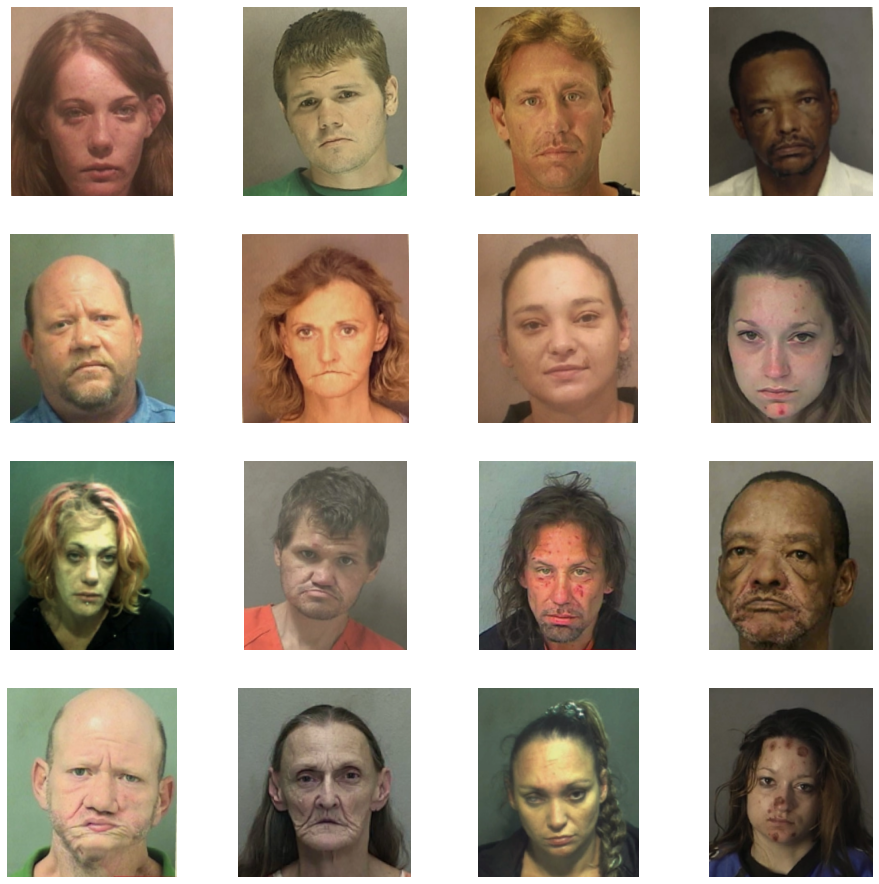

In [9]:
# Visualisasi gambar sebanyak 4x4, 8 gambar atas untuk before, 8 gambar bawah untuk after
fig = plt.gcf()
fig.set_size_inches(cols*4, rows*4)

indexes+=8

before_picture = [os.path.join(train_before_dir, fname) for fname in before_filenames[indexes-8:indexes]]

after_picture = [os.path.join(train_after_dir, fname) for fname in after_filenames[indexes-8:indexes]]

for i, img_path in enumerate(before_picture+after_picture):
  vis = plt.subplot(rows, cols, i + 1)
  vis.axis('off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### **Preprocessing Data**

In [ ]:
# Preprocessing data
#train_data = tf.keras.preprocessing.image_dataset_from_directory(
#  data_dir,
#  validation_split=0.2,
#  subset="training",
#  seed=123,
#  image_size=(150, 150),
#  batch_size=32)

Found 26 files belonging to 2 classes.
Using 21 files for training.


In [ ]:
#classes = train_data.class_names
#print(classes)

['after', 'before']


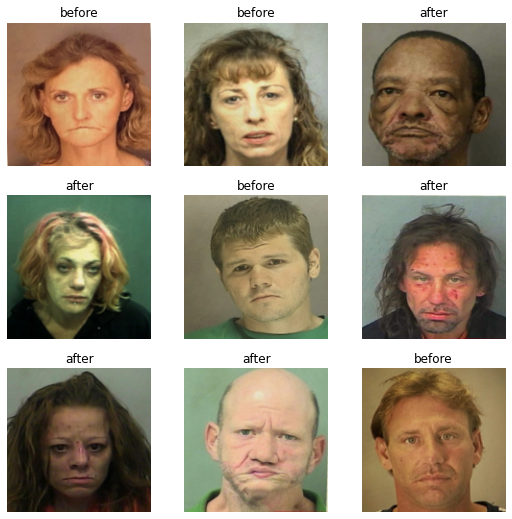

In [ ]:
#import matplotlib.pyplot as plt

#plt.figure(figsize=(9, 9))
#for images, label in train_data.take(1):
#  for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(images[i].numpy().astype("uint8"))
#    plt.title(classes[label[i]])
#    plt.axis("off")

In [ ]:
#for image_batch, labels_batch in train_data:
#  print(image_batch.shape)
#  print(labels_batch.shape)
#  break

(21, 150, 150, 3)
(21,)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale gambar
train_data = ImageDataGenerator(rescale = 1.0/255.)
#test_data  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Mengalirkan pelatihan gambar dalam 20 batch menggunakan generator train_data
# --------------------
train_generator = train_data.flow_from_directory(data_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
#validation_generator =  test_datagen.flow_from_directory(validation_dir,
#                                                         batch_size=20,
#                                                         class_mode  = 'binary',
#                                                         target_size = (150, 150))

Found 26 images belonging to 2 classes.


### **Build the Model**

In [11]:
# Membangun Model
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation ='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 39200)             0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### **Training Data**

In [ ]:
model.fit(train_generator,
          validation_data=validation_generator,
          steps_per_epoch=100,
          epochs=15,
          validation_steps=50,
          verbose=2)

### **Testing Data**

### **Evaluating Accuracy and Loss Model**

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )